# SVM with Docking Scores

In [2]:
import pandas as pd
import numpy as np
import glob, os, sys
sys.path.append('..')

## Ensemble Docking con ligandos CSAR
- #### 111 ligandos
    - 27 Activos
- #### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [20]:
def open_results(path, column_to_drop, active_label='Active'):
    '''Function to load VS results from path file. It returns X and y ndarrays.'''
    path_file = os.path.join(*path.split('/'))
    df_results = pd.read_csv(path_file, index_col=0)
    y_ = pd.Series(df_results[column_to_drop] == active_label, dtype = int) # Setting y_true
    X_ = df_results.drop([column_to_drop], axis = 1) # Setting X
    return X_, y_

In [18]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_CSAR, y_dksc_CSAR = open_results(path = '../data/vs_docking_crys_ensemble_VINARDO.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dksc_CSAR", X_dksc_CSAR.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_CSAR, y_dkef_CSAR = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_CSAR_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'ActiveInactive')
print(F"Dims X_dkef_CSAR", X_dkef_CSAR.shape)

Dims X_dksc_CSAR (111, 402)
Dims X_dkef_CSAR (111, 402)


## Ensemble Docking con ligandos DUD (2006)
- ### 2146 ligandos
    - 72 Activos
- ### 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales

In [22]:
# Vinardo Docking Scores (dksc) CSAR
X_dksc_DUD, y_dksc_DUD = open_results(path = '../data/vs_docking_DUD2006_vs_402_crys_vinardo_8x.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dksc_DUD", X_dksc_DUD.shape)

# Vinardo Ligand Efficiency (dkef) Scores CSAR
X_dkef_DUD, y_dkef_DUD = \
open_results(path = '../data/docking_scores/vs_dk_CRYS_402_DUD2006_VINARDO_ligand_Efficiency.csv',
                                        column_to_drop = 'Actividad')
print(F"Dims X_dkef_DUD", X_dkef_DUD.shape)

Dims X_dksc_DUD (2146, 402)
Dims X_dkef_DUD (2146, 402)


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score

In [43]:
def run_SVM(X_train, X_test, y_train, y_test, 
            C = np.geomspace(0.01, 100, 6), kernel='linear', **kwargs):
    SVCpipe = Pipeline([
            ("scaler", StandardScaler()),
            ("SVC", SVC(kernel= kernel, probability = True, **kwargs))])
    params = {'SVC__C': C}
    # Grid search for turning the optimal parameters
    linear_SVC = GridSearchCV(SVCpipe, params, scoring = 'roc_auc', iid = False,
                             refit=True, cv = 5, return_train_score = True)
    # grid training
    linear_SVC.fit(X_train, y_train)
    # scaling and prediction of X_train using the bes model found by grid
    y_train_pred = linear_SVC.predict(X_train)
    # scaling and prediction of X_train using the bes model found by grid
    y_pred  = linear_SVC.predict(X_test) # Predicted values for X_test
    y_score = linear_SVC.decision_function(X_test) # Hyperplane distances
    roc_auc = roc_auc_score(y_true = y_test, y_score = y_score)
    return(y_score, linear_SVC.best_estimator_)

In [44]:
from modules.plotting_metrics import PlotMetric

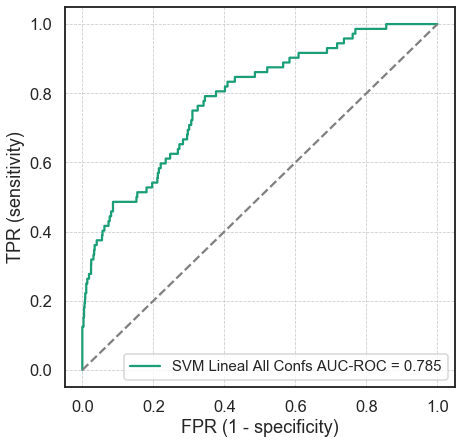

In [57]:
X_train = X_dksc_CSAR
y_train = y_dksc_CSAR
X_test = X_dksc_DUD
y_test = y_dksc_DUD

y_score, svc = run_SVM(X_train, X_test, y_train, y_test)

prueba_1 = PlotMetric(y_true = y_test.to_numpy(), y_pred_dict = {'SVM Lineal All Confs': y_score})

prueba_1.plot_roc_auc('')

In [46]:
def plot_roc(y_true, y_score, subplot = None):
    sns.set( context = 'talk', style = 'white', palette = "Set2")
    with sns.color_palette("Set2", 2):
        fpr, tpr, thresholds = roc_curve(y_true = y_true, y_score = y_score)
        auc = roc_auc_score( y_true = y_true, y_score = y_score)
        if subplot is not None:
            plt.subplot(subplot)
        plt.grid(linestyle='--', linewidth='0.8')
        plt.xlabel("FPR (1 - specificity)")
        plt.ylabel("TPR (sensitivity)")
        plt.title('ROC AUC')
        plt.plot(fpr, tpr, label='AUC = %0.3f' % auc, lw = 4)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.legend()

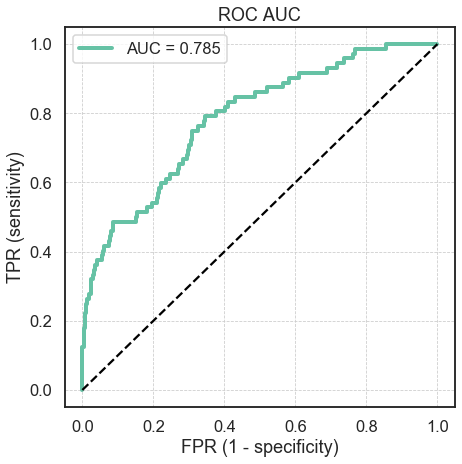

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize= (7,7)); plt.subplots_adjust(hspace = 0.3)
plot_roc(y_test, y_score)